In [1]:
%reset -f

import os
import numpy as np
import pandas as pd
import random
import math
from math import e

import matplotlib
import matplotlib.pyplot as plt
import configparser

from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FuncFormatter

In [11]:
def load_data():
    """Lee los datos del directorio de trabajo.
    """
    global pathoutput
    global nodos, inv, vu, cartectraf, cyd
    global HSCD, PVDT, TNTR, TAMB, PDRE, FCMX, FCPR, HVUT, AVUT
    global P1FVAC1, P1FVAC2, P1FCAR1, P1FCAR2, P1FCAR3, P1FCAR4
    global P3FVAC11, P3FVAC12, P3FVAC21, P3FVAC22, P3FVAC31, P3FVAC32
    global P3FCAR11, P3FCAR12, P3FCAR13, P3FCAR21, P3FCAR22, P3FCAR31, P3FCAR32

    pathoutput= 'ResRecomendaciones/'
    pathinput = "../Tests/Test11/input/"
    
    #######################################################
    # definicion del archivo txt donde estan los parametros
    parser = configparser.ConfigParser()
    parser.read(pathinput + 'params.txt')

    # parametros globales
    HSCD = float(parser['CALCULOS']['horas_sobrecarga_dia'])
    PVDT = float(parser['CALCULOS']['perdida_vida_diaria_teorica'])
    TNTR = float(parser['CALCULOS']['temperatura_normal_trafo'])
    TAMB = float(parser['CALCULOS']['temperatura_ambiente'])
    PDRE = float(parser['CALCULOS']['probabilidad_deterioro_reubicacion'])
    FCMX = float(parser['CALCULOS']['factor_carga_maxima'])
    FCPR = float(parser['CALCULOS']['factor_carga_promedio'])

    # calculos con parametros globales
    HVUT = 24 / PVDT
    AVUT = HVUT / (24*365) 

    # resoluciones 818 y 819
    ## transformadores monofasicos - perdidas en vacio
    P1FVAC1 = float(parser['RES818819']['P1FVAC1'])
    P1FVAC2 = float(parser['RES818819']['P1FVAC2'])

    ## transformadores monofasicos - perdidas con carga
    P1FCAR1 = float(parser['RES818819']['P1FCAR1'])
    P1FCAR2 = float(parser['RES818819']['P1FCAR2'])
    P1FCAR3 = float(parser['RES818819']['P1FCAR3'])
    P1FCAR4 = float(parser['RES818819']['P1FCAR4'])

    ## transformadores trifasicos -- perdidas en vacio
    P3FVAC11 = float(parser['RES818819']['P3FVAC11'])
    P3FVAC12 = float(parser['RES818819']['P3FVAC12'])
    P3FVAC21 = float(parser['RES818819']['P3FVAC21'])
    P3FVAC22 = float(parser['RES818819']['P3FVAC22'])
    P3FVAC31 = float(parser['RES818819']['P3FVAC31'])
    P3FVAC32 = float(parser['RES818819']['P3FVAC32'])

    ## transformadores trifasicos - perdidas con carga
    P3FCAR11 = float(parser['RES818819']['P3FCAR11'])
    P3FCAR12 = float(parser['RES818819']['P3FCAR12'])
    P3FCAR13 = float(parser['RES818819']['P3FCAR13'])
    P3FCAR21 = float(parser['RES818819']['P3FCAR21'])
    P3FCAR22 = float(parser['RES818819']['P3FCAR22'])
    P3FCAR31 = float(parser['RES818819']['P3FCAR31'])
    P3FCAR32 = float(parser['RES818819']['P3FCAR32'])

    #######################################################
    
    # lectura de las tablas de datos
    nodos = pd.read_csv(pathinput + "nodos.csv", sep=',', decimal='.')
    inv = pd.read_csv(pathinput + "inventario_transformadores.csv", sep=',', decimal='.',encoding = "ISO-8859-1")
    cartectraf = pd.read_csv(pathinput + "carac_tecn_transf.csv", sep=',', decimal='.')
    vu = pd.read_csv(pathinput + "vida_util.csv", sep=',', decimal='.')
    cyd = pd.read_csv(pathinput + "cyd_pornodo.csv", sep=',', decimal='.')

    # limpieza de datos
    # eliminar columnas en blanco
    nodos=nodos.drop(nodos.columns[nodos.columns.str.contains('unnamed',case = False)],axis = 1)
    inv=inv.drop(inv.columns[inv.columns.str.contains('unnamed',case = False)],axis = 1)

    # agregar columna con id_n y id_t
    nodos.insert(0, 'id_n', range(1, 1+len(nodos)))
    inv.insert(0, 'id_t', range(1, 1+len(inv)))

    # eliminar filas que sobran
    nodos=nodos.loc[(nodos.id_nodo.notnull())]
    
    # eliminar las comas
    nodos.columns = [col.replace(',','') for col in nodos.columns]

    ############################################################
    
    # nombres de las columnas de las tablas de datos
    nodos.columns = ['id_n', 'id_n_Internexa','lat','lon','tension','cpro_n','cmax_n','cremcreg','dmda_n','cens','cred','tusu','pkwh_n']
    inv.columns = ['id_t', 'id_t_Internexa','fab','fase_t','tais','capa_t','vprim','vsecu','ffab','anus','viut_t','id_n_Internexa','tacr_t','creu_t','finst']
    vu.columns = ['tgrc', 'fase_t','lipo','lspo','cpre','dura','cpor','tmpc','tmac']
    cartectraf.columns = ['fase_t', 'capa_t','cnue_t']
    cyd.columns = ['id','id_t_Internexa','cmax','cprom','ddadia']

    # señalar la bodega
    nodos.loc[nodos.id_n_Internexa == 'Palmira','id_n']=999999
    nodos.loc[nodos.id_n == 999999,'dmda_n']=0
    # eliminar las comas de los campos con valores
    cols = ['cpro_n','cmax_n','dmda_n','pkwh_n']
    nodos[cols] = nodos[cols].replace({'\$': '', ',': ''}, regex=True)
    nodos[cols] = nodos[cols].apply(pd.to_numeric, errors='coerce', axis=1)
    cols = ['capa_t','ffab','anus','viut_t','creu_t','viut_t','anus']
    inv[cols] = inv[cols].replace({'\$': '', ',': ''}, regex=True)
    inv[cols] = inv[cols].apply(pd.to_numeric, errors='coerce', axis=1)
    
    # agregar la carga maxima y carga promedio de los nodos
    inv.id_t_Internexa = inv.id_t_Internexa.apply(str)
    cyd.id_t_Internexa = cyd.id_t_Internexa.apply(str)
    inv = inv.merge(nodos[['id_n','id_n_Internexa']], on = 'id_n_Internexa',how = 'left')
    inv = inv.merge(cyd[['cmax','cprom','id_t_Internexa']], on = 'id_t_Internexa',how = 'left')
    nodos = nodos.merge(inv.loc[inv.id_n_Internexa != 'Palmira'][['cmax','cprom','id_n_Internexa']], on = 'id_n_Internexa',how = 'left')
    nodos['cpro_n'] = nodos['cprom']
    nodos['cmax_n'] = nodos['cmax']
    nodos.drop(['cprom', 'cmax'], inplace=True, axis=1)
    inv.drop(['cprom', 'cmax'], inplace=True, axis=1)
    # en caso de que no se disponga de informacion historica del comportamiento del nodo se usan indicadores nacionales
    nodos.loc[(nodos['cpro_n'].isnull()) & (nodos['id_n'] != 999999),'cpro_n'] = nodos['dmda_n'] / 30 * FCPR
    nodos.loc[(nodos['cmax_n'].isnull()) & (nodos['id_n'] != 999999),'cmax_n'] = nodos['dmda_n'] / 30 * FCMX

    # indicar grupo del trafo para calculo de las perdidas de transformacion
    inv['grpt_t'] = 1
    inv.loc[(inv.fase_t == 3) & (inv.capa_t >= 150), 'grpt_t'] = 2
    inv.loc[(inv.fase_t == 3) & (inv.capa_t >= 800), 'grpt_t'] = 3

    # indicar grupo del trafo para calculo de las perdidas de vida util
    inv['grpv_t'] = 1
    inv.loc[(inv.fase_t == 1) & (inv.capa_t > 50), 'grpv_t'] = 2
    inv.loc[(inv.fase_t == 3) & (inv.capa_t >= 150), 'grpv_t'] = 2
    inv.loc[(inv.fase_t == 3) & (inv.capa_t >= 500), 'grpv_t'] = 3

    # calcular los años de uso a partir de la fecha de instalación
    ano = inv['finst'].astype(str).str[0:4]
    ano = ano.apply(pd.to_numeric, errors='coerce')
    inv['anus']=2018-ano
    #los trafos en operación sin años de uso se asumen con los años de uso promedio de todo el parque de trafos
    inv.loc[inv.anus.isnull(),'anus']=inv.anus.mean()
    #supuesto: todos los trafos de bodega están nuevos
    inv.loc[(inv['finst'].isnull()) & (inv['id_n']==999999),'anus']=0

    # calcular vida util restante del trafo en meses
    inv['viut_t'] = AVUT
    inv['viur_t'] = (inv.viut_t - inv.anus) * 12
    inv.loc[inv.viur_t < 0, 'viur_t'] = 1

    # indicar grupo de vida util
    vu['grpv_t'] = 1
    vu.loc[(vu.fase_t == 1) & (vu.lipo >= 50), 'grpv_t'] = 2
    vu.loc[(vu.fase_t == 3) & (vu.lipo >= 150),'grpv_t'] = 2
    vu.loc[(vu.fase_t == 3) & (vu.lipo >= 500), 'grpv_t'] = 3

    # armar keys para busquedas
    cartectraf['faca'] = cartectraf.fase_t.map(str) + "-" + cartectraf.capa_t.map(str)
    vu['tfcg'] = vu.tgrc.map(str) + "-" + vu.fase_t.map(str) + "-" + vu.cpre.map(str) + "-" + vu['grpv_t'].map(str)
    
    # calculo del costo de cada KVA instalado en la bodega en la solucion inicial
    inv2=inv.copy()
    inv2['faca'] = inv2.fase_t.map(str) + "-" + inv2.capa_t.map(str)
    inv2 = inv2.merge(cartectraf[['cnue_t','faca']], on = 'faca',how = 'left')
    totalcap = inv2['capa_t'].sum()
    totalvalor = inv2['cnue_t'].sum()
    precioKVAbod = int(totalvalor / totalcap)

In [3]:
# funciones core

def cospt(cmax_n,pkwh_n,capa_t,fase_t):
    faca_t = str(fase_t) + '-' + str(capa_t)
    grpt_t = 1
    if (fase_t == 3 and capa_t >= 150): grpt_t = 2
    if (fase_t == 3 and capa_t >= 800): grpt_t = 3

    futi_nt = cmax_n / capa_t

    # calcular perdidas nominales en vacio y perdidas nominales con carga en funcion de las fases y el grupo en la fase
    if fase_t == 1:
        pnvac = P1FVAC1 * capa_t ** P1FVAC2
        pncar = P1FCAR1 * capa_t ** 3 + P1FCAR2 * capa_t ** 2 + P1FCAR3 * capa_t + P1FCAR4
    else:
        if grpt_t == 1:
            pnvac = P3FVAC11 * capa_t ** P3FVAC12
            pncar = P3FCAR11 * capa_t ** 2 + P3FCAR12 * capa_t + P3FCAR13
        if grpt_t == 2:
            pnvac = P3FVAC21 * capa_t ** P3FVAC22
            pncar = P3FCAR21 * capa_t + P3FCAR22
        if grpt_t == 3:
            pnvac = P3FVAC31 * capa_t ** P3FVAC32
            pncar = P3FCAR31 * capa_t + P3FCAR32

    # calcular las perdidas en hierro y cobre en unidades W 
    pfeW = pnvac
    pcuW = pncar * futi_nt ** 2
    ptrW = pfeW + pcuW

    # monetizacion de las perdidas
    cpfe_nt = pfeW / 1000 * pkwh_n * 24 * 30
    cpcu_nt = pcuW / 1000 * pkwh_n * 24 * 30
    cpt_nt = ptrW / 1000 * pkwh_n * 24 * 30
    return (pfeW,pcuW,ptrW,cpfe_nt,cpcu_nt,cpt_nt,futi_nt,faca_t)


def cosvu(cmax_n,cpro_n,capa_t,fase_t,cnue_t):
    # hallar parametros del nodo y del trafo
    grpv_t = 1
    if (fase_t == 1 and capa_t > 50): grpv_t = 2
    if (fase_t == 3 and capa_t >= 150): grpv_t = 2
    if (fase_t == 3 and capa_t >= 500): grpv_t = 3
    
    # calcular la carga precedente y el factor de utilizacion
    cpre_nt = cpro_n / capa_t
    futi_nt = cmax_n / capa_t

    # aproximar la carga precedente a los valores de la norma GTC50
    if cpre_nt < ((0.5 + 0.75) / 2):
        cpre_nt = 0.5
    else:
        if cpre_nt < ((0.75 + 0.9) / 2):
            cpre_nt = 0.75
        else:
            cpre_nt = 0.9

    # calcular el porcentaje diario de perdida de vida util real en porcentaje
    key = str(int(TAMB)) + '-' + str(fase_t) + '-' + str(cpre_nt) + '-' + str(grpv_t)
    theta = temperPC(futi_nt,key)
    fevej = (HSCD / 24) * (e**(15000/383 - 15000/(theta + 273))-1)
    pvdr = PVDT * (1 + fevej)

    # valorar perdida de vida util restante en pesos, durante lo que queda de vida util del trafo en el nodo 
    cvu_nt = cnue_t * pvdr * 30
    viur_r = 12 / (pvdr * 365)
    return (cvu_nt, viur_r)


def temperPC(futi_nt, key):
    tabvu = vu.loc[(vu.tfcg == str(key)) & (vu.dura <= HSCD)]
    ncargas = tabvu.shape[0]
    carga=futi_nt * 100
    theta=0
    if carga < tabvu['cpor'].min(): theta = TNTR
    if carga >= tabvu['cpor'].max(): theta = tabvu['tmpc'].max()
    if theta == 0:
        tabvu = tabvu.sort_values(['cpor'],ascending=[False])
        for index, row in tabvu.iterrows():
            if carga <= row['cpor']:
                theta = row['tmpc']
                break
    return theta 


def costopermtf(id_t):
    viur_t = float(inv[inv.id_t == id_t]['viur_t'])
    cperm_t = float(inv[inv.id_t == id_t]['creu_t']) / viur_t
    return cperm_t


def costodetetf(id_t):
    cnue_t = partf(id_t)[9]
    viur_t = float(inv[inv.id_t == id_t]['viur_t'])
    cdete_t = cnue_t * PDRE / viur_t
    return cdete_t

#funcion para darle formato al eje y en millones
def millions(x, pos):
    'The two args are the value and tick position'
    return '$%1.0fM' % (x*1e-6)

#funcion para darle formato al eje y en millones
def millions2(x, pos):
    'The two args are the value and tick position'
    return '$%1.1fM' % (x*1e-6)


In [12]:
#working_dir="../Tests/Test10/"
load_data()

# vectores de datos
fa_t = [1,1,1,1,1,1,1,1,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3]
cp_t = [5,7.5,10,15,25,37.5,50,75,15,25,30,37.5,45,50,60,75,112.5,150,225,250,300,400,500]
cn_t = [1586217,1708814,1831410,2136748,2442086,2997610,3457763,4458731,2979760,3246915,3514070,3733024,3951977,4315194,4678411,5041628,5888415,7851220,11776830,13085367,15702440,20936587,26170733]


In [16]:
# calculos del comportamiento de un trafo específico ante diferentes cargas de nodo
pkwh = 510
cmx=pd.Series(range(0,100,1))
cmx=cmx.append(pd.Series(range(100,500,50)))
cmx=cmx.append(pd.Series(range(500,1100,100)))
cmx=cmx.reset_index(drop=True)
cuenta = 0
                   
matriz = pd.DataFrame(columns=['cmax','cpro','fases','pfeW','pcuW','ptrW','cpfe_nt','cpcu_nt','cpt_nt','futi_nt','faca_t','capa','cvu_nt','viur_r'])
for i in range (len(cmx)):
    cmax = int(cmx[i])
    cpro = cmax * 0.4  
    for j in range (len(cp_t)):
        cuenta += 1
        capa = cp_t[j]
        fases = fa_t[j]
        cnue = cn_t[j]
        pfeW,pcuW,ptrW,cpfe_nt,cpcu_nt,cpt_nt,futi_nt,faca_t = cospt(cmax,pkwh,capa,fases)
        cvu_nt,viur_r = cosvu(cmax,cpro,capa,fases,cnue)
        matriz.loc[cuenta]=[cmax,cpro,fases,pfeW,pcuW,ptrW,cpfe_nt,cpcu_nt,cpt_nt,futi_nt,faca_t,capa,cvu_nt, viur_r]
matriz['ctotal']= matriz['cpt_nt'] + matriz['cvu_nt']
        
#reemplazar
df = matriz.copy()

df.loc[(df['faca_t']=='1-5'),'faca_t'] = [['a-1-5']]
df.loc[(df['faca_t']=='1-7.5'),'faca_t'] = [['b-1-7.5']]
df.loc[(df['faca_t']=='1-10'),'faca_t'] = [['c-1-10']]
df.loc[(df['faca_t']=='1-15'),'faca_t'] = [['d-1-15']]
df.loc[(df['faca_t']=='1-25'),'faca_t'] = [['e-1-25']]
df.loc[(df['faca_t']=='1-37.5'),'faca_t'] = [['f-1-37.5']]
df.loc[(df['faca_t']=='1-50'),'faca_t'] = [['g-1-50']]
df.loc[(df['faca_t']=='1-75'),'faca_t'] = [['h-1-75']]
df.loc[(df['faca_t']=='3-15'),'faca_t'] = [['i-3-15']]
df.loc[(df['faca_t']=='3-25'),'faca_t'] = [['j-3-25']]
df.loc[(df['faca_t']=='3-30'),'faca_t'] = [['k-3-30']]
df.loc[(df['faca_t']=='3-37.5'),'faca_t'] = [['l-3-37.5']]
df.loc[(df['faca_t']=='3-45'),'faca_t'] = [['m-3-45']]
df.loc[(df['faca_t']=='3-50'),'faca_t'] = [['n-3-50']]
df.loc[(df['faca_t']=='3-60'),'faca_t'] = [['o-3-60']]
df.loc[(df['faca_t']=='3-75'),'faca_t'] = [['p-3-75']]
df.loc[(df['faca_t']=='3-112.5'),'faca_t'] = [['q-3-112.5']]
df.loc[(df['faca_t']=='3-150'),'faca_t'] = [['r-3-150']]
df.loc[(df['faca_t']=='3-225'),'faca_t'] = [['s-3-225']]
df.loc[(df['faca_t']=='3-250'),'faca_t'] = [['t-3-250']]
df.loc[(df['faca_t']=='3-300'),'faca_t'] = [['u-3-300']]
df.loc[(df['faca_t']=='3-400'),'faca_t'] = [['v-3-400']]
df.loc[(df['faca_t']=='3-500'),'faca_t'] = [['w-3-500']]

#resetear index
df.set_index('cmax', inplace=True)
#df.to_csv(pathoutput + 'df.csv')

In [22]:
# verificacion del adecuado funcionamiento de las funciones

cvu_nt,viur_r = cosvu(6.38,3.272861111,50,3,4315194)
pfeW,pcuW,ptrW,cpfe_nt,cpcu_nt,cpt_nt,futi_nt,faca_t = cospt(6.38,457.3,50,3)
print(cpt_nt,cvu_nt)

cvu_nt,viur_r = cosvu(6.38,3.272861111,10,1,1831410)
pfeW,pcuW,ptrW,cpfe_nt,cpcu_nt,cpt_nt,futi_nt,faca_t = cospt(6.38,457.3,10,1)
print(cpt_nt,cvu_nt)


68894.06122342318 17735.44734
35769.689564251654 7527.0951


In [36]:
##############
### analisis con trafo fijo y carga de nodo variable
##############

In [18]:
# una sola grafica
W = df.loc[df['faca_t']=='w-3-500',:]
W = W.reset_index()
x=W['cmax']

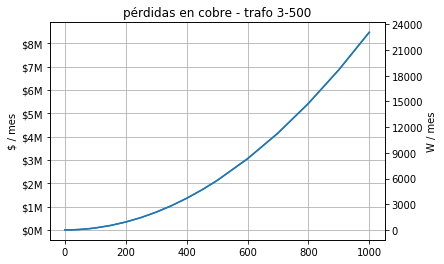

In [19]:
# cobre
y1=W['pcuW']
y2=W['cpcu_nt']

fig, ax1 = plt.subplots()

ax1.plot(x,y2)
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
formatter = FuncFormatter(millions)
ax1.yaxis.set_major_formatter(formatter)
ax1.set_ylabel('$ / mes')
ax1.tick_params(axis='y')
plt.title('pérdidas en cobre - trafo 3-500')
plt.grid(True)

#agregar el segundo eje
ax2 = ax1.twinx()
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax2.plot(x, y1)
ax2.set_ylabel('W / mes')

plt.show()

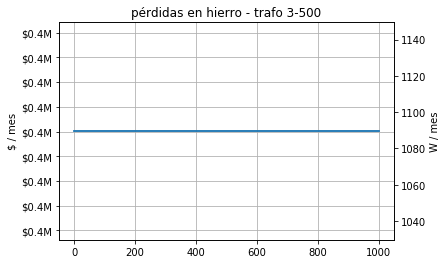

In [20]:
# hierro
y1=W['pfeW']
y2=W['cpfe_nt']

fig, ax1 = plt.subplots()

ax1.plot(x,y2)
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_yticklabels(['{:,}'.format(int(x)) for x in ax1.get_yticks().tolist()])
formatter = FuncFormatter(millions2)
ax1.yaxis.set_major_formatter(formatter)
ax1.set_ylabel('$ / mes')
ax1.tick_params(axis='y')
plt.title('pérdidas en hierro - trafo 3-500')
plt.grid(True)

#agregar el segundo eje
ax2 = ax1.twinx()
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
ax2.plot(x, y1)
ax2.set_ylabel('W / mes')  # we already handled the x-label with ax1

plt.show()

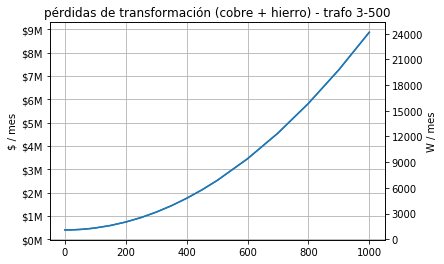

In [21]:
# totales
y1=W['ptrW']
y2=W['cpt_nt']

fig, ax1 = plt.subplots()

ax1.plot(x,y2)
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_yticklabels(['{:,}'.format(int(x)) for x in ax1.get_yticks().tolist()])
formatter = FuncFormatter(millions)
ax1.yaxis.set_major_formatter(formatter)
ax1.set_ylabel('$ / mes')
ax1.tick_params(axis='y')
plt.title('pérdidas de transformación (cobre + hierro) - trafo 3-500')
plt.grid(True)

#agregar el segundo eje
ax2 = ax1.twinx()
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax2.plot(x,y1)
ax2.set_ylabel('W / mes')

plt.show()

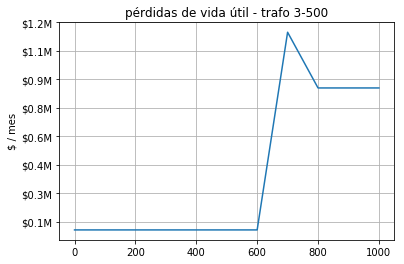

In [22]:
# vida útil
y1=W['cvu_nt']

fig, ax1 = plt.subplots()
ax1.plot(x,y1)
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_yticklabels(['{:,}'.format(int(x)) for x in ax1.get_yticks().tolist()])
formatter = FuncFormatter(millions2)
ax1.yaxis.set_major_formatter(formatter)
ax1.set_ylabel('$ / mes')
plt.title('pérdidas de vida útil - trafo 3-500')
plt.grid(True)

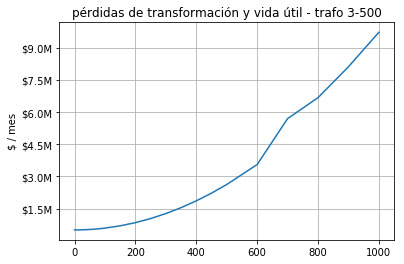

In [23]:
# total: cobre + hierro + vida útil
y1=W['ctotal']

fig, ax1 = plt.subplots()
ax1.plot(x,y1)
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_yticklabels(['{:,}'.format(int(x)) for x in ax1.get_yticks().tolist()])
formatter = FuncFormatter(millions2)
ax1.yaxis.set_major_formatter(formatter)
ax1.set_ylabel('$ / mes')
plt.title('pérdidas de transformación y vida útil - trafo 3-500')
plt.grid(True)

In [52]:
###### para todas las gráficas


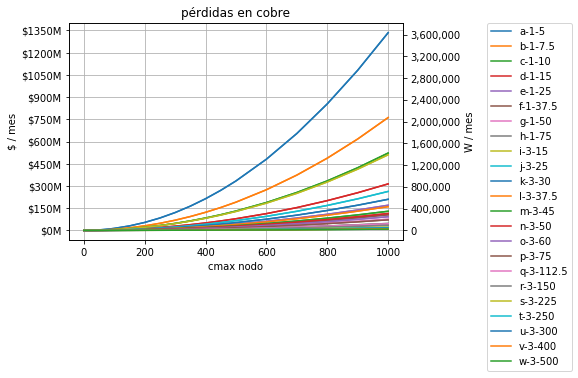

In [24]:
# cobre

fig, ax1 = plt.subplots()

a = df.groupby('faca_t')['cpcu_nt']
a.plot(x='cmax', y='cpcu_nt',ax=ax1)
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
formatter = FuncFormatter(millions)
ax1.yaxis.set_major_formatter(formatter)
plt.ylabel('$ / mes')
plt.xlabel('cmax nodo')
plt.title('pérdidas en cobre')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.25, 1), loc=2, borderaxespad=0.)

#agregar el segundo eje
ax2 = ax1.twinx()
b = df.groupby('faca_t')['pcuW']
b.plot(x='cmax', y='pcuW',ax=ax2)
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_yticklabels(['{:,}'.format(int(x)) for x in ax2.get_yticks().tolist()])
ax2.set_ylabel('W / mes')

plt.show()

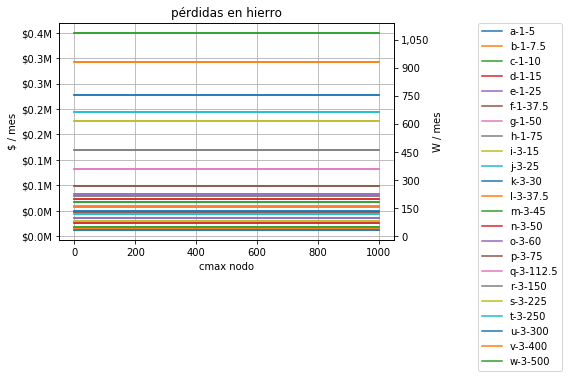

In [25]:
# hierro

fig, ax1 = plt.subplots()

a = df.groupby('faca_t')['cpfe_nt']
a.plot(x='cmax', y='cpfe_nt',ax=ax1)
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
formatter = FuncFormatter(millions2)
ax1.yaxis.set_major_formatter(formatter)
plt.ylabel('$ / mes')
plt.xlabel('cmax nodo')
plt.title('pérdidas en hierro')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.25, 1), loc=2, borderaxespad=0.)

#agregar el segundo eje
ax2 = ax1.twinx()
b = df.groupby('faca_t')['pfeW']
b.plot(x='cmax', y='pfeW',ax=ax2)
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_yticklabels(['{:,}'.format(int(x)) for x in ax2.get_yticks().tolist()])
ax2.set_ylabel('W / mes')

plt.show()

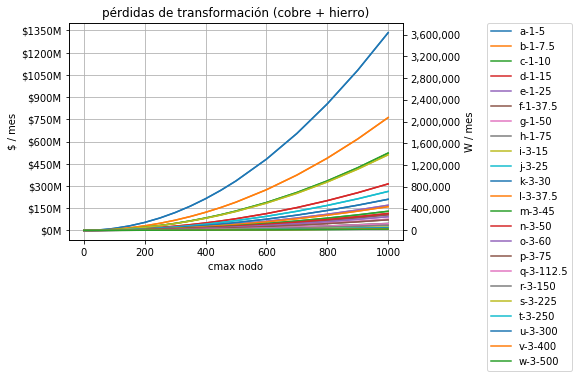

In [26]:
# de transformación (cobre + hierro)

fig, ax1 = plt.subplots()

a = df.groupby('faca_t')['cpt_nt']
a.plot(x='cmax', y='cpt_nt',ax=ax1)
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
formatter = FuncFormatter(millions)
ax1.yaxis.set_major_formatter(formatter)
plt.ylabel('$ / mes')
plt.xlabel('cmax nodo')
plt.title('pérdidas de transformación (cobre + hierro)')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.25, 1), loc=2, borderaxespad=0.)

#agregar el segundo eje
ax2 = ax1.twinx()
b = df.groupby('faca_t')['ptrW']
b.plot(x='cmax', y='ptrW',ax=ax2)
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_yticklabels(['{:,}'.format(int(x)) for x in ax2.get_yticks().tolist()])
ax2.set_ylabel('W / mes')

plt.show()

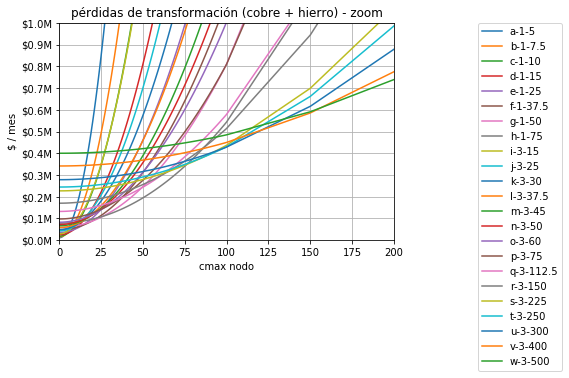

In [27]:
# de transformación (cobre + hierro) - zoom

fig, ax1 = plt.subplots()

a = df.groupby('faca_t')['cpt_nt']
a.plot(x='cmax', y='cpt_nt',ax=ax1)

plt.ylabel('$ / mes')
plt.xlabel('cmax nodo')
plt.title('pérdidas de transformación (cobre + hierro) - zoom')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.25, 1), loc=2, borderaxespad=0.)

plt.xlim(0, 200)
plt.ylim(0, 1000000)
ax1.set_yticklabels(['{:,}'.format(int(x)) for x in ax1.get_yticks().tolist()])
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
formatter = FuncFormatter(millions2)
ax1.yaxis.set_major_formatter(formatter)

plt.show()


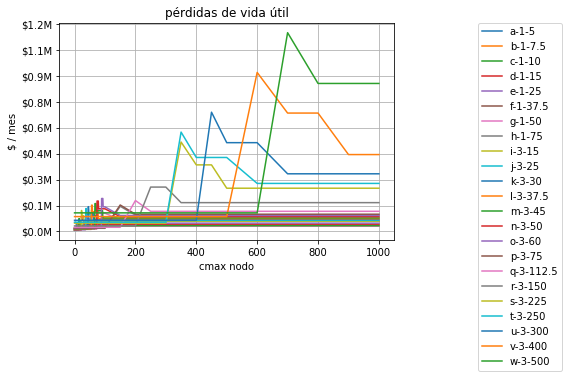

In [28]:
# de vida útil

fig, ax1 = plt.subplots()

a = df.groupby('faca_t')['cvu_nt']
a.plot(x='cmax', y='cvu_nt',ax=ax1)
ax1.set_yticklabels(['{:,}'.format(int(x)) for x in ax1.get_yticks().tolist()])
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
formatter = FuncFormatter(millions2)
ax1.yaxis.set_major_formatter(formatter)

plt.ylabel('$ / mes')
plt.xlabel('cmax nodo')
plt.title('pérdidas de vida útil')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.25, 1), loc=2, borderaxespad=0.)

plt.show()

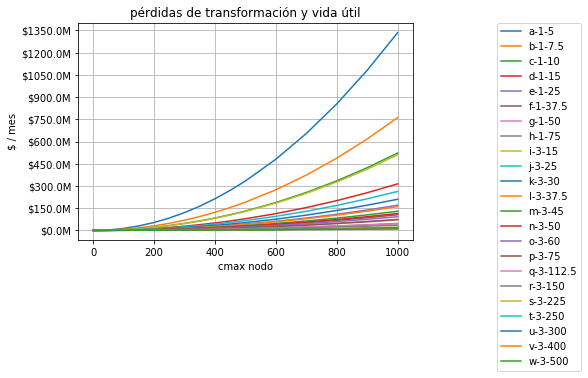

In [29]:
# totales

fig, ax1 = plt.subplots()

a = df.groupby('faca_t')['ctotal']
a.plot(x='cmax', y='ctotal',ax=ax1)
ax1.set_yticklabels(['{:,}'.format(int(x)) for x in ax1.get_yticks().tolist()])
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
formatter = FuncFormatter(millions2)
ax1.yaxis.set_major_formatter(formatter)

plt.ylabel('$ / mes')
plt.xlabel('cmax nodo')
plt.title('pérdidas de transformación y vida útil')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.25, 1), loc=2, borderaxespad=0.)

plt.show()


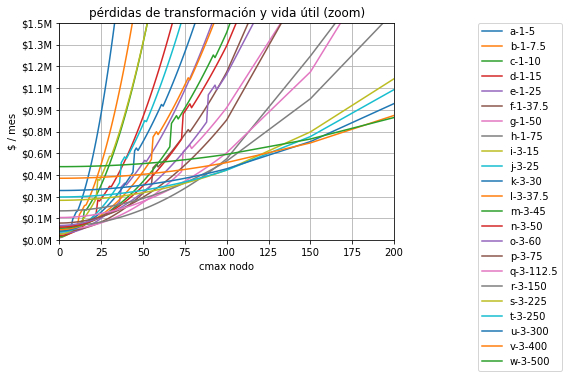

In [30]:
# totales - zoom

fig, ax1 = plt.subplots()

a = df.groupby('faca_t')['ctotal']
a.plot(x='cmax', y='ctotal',ax=ax1)
ax1.set_yticklabels(['{:,}'.format(int(x)) for x in ax1.get_yticks().tolist()])
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
formatter = FuncFormatter(millions2)
ax1.yaxis.set_major_formatter(formatter)
plt.xlim(0, 200)
plt.ylim(0, 1500000)
plt.ylabel('$ / mes')
plt.xlabel('cmax nodo')
plt.title('pérdidas de transformación y vida útil (zoom)')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.25, 1), loc=2, borderaxespad=0.)

plt.show()

In [36]:
#tabla maestra para sugerir el trafo menos costoso para cargas específicas en el nodo
grupos = df.groupby(['cmax'])
rec = pd.DataFrame(grupos['ctotal'].min())
rec['cmax'] = rec.index.get_level_values('cmax')
rec = rec.reset_index(drop=True)
rec = rec[rec.cmax != 0]
rec = rec.merge(df[['faca_t','ctotal']], on = 'ctotal',how = 'left')
rec['ctotal']=rec['ctotal'].map(int)
rec = rec.loc[:,('cmax','faca_t','ctotal')]
rec.loc[-1] = [0, rec.loc[0,'faca_t'], rec.loc[0,'ctotal']]
rec = rec.sort_values(['cmax'],ascending=[True])
rec['cmax']=rec['cmax'].astype(float)

#renombrar trafos para facilidad en la lectura de la tabla
rec.loc[(rec['faca_t']=='a-1-5'),'faca_t'] = [['1--5']]
rec.loc[(rec['faca_t']=='b-1-7.5'),'faca_t'] = [['1--7.5']]
rec.loc[(rec['faca_t']=='c-1-10'),'faca_t'] = [['1--10']]
rec.loc[(rec['faca_t']=='d-1-15'),'faca_t'] = [['1--15']]
rec.loc[(rec['faca_t']=='e-1-25'),'faca_t'] = [['1--25']]
rec.loc[(rec['faca_t']=='f-1-37.5'),'faca_t'] = [['1--37.5']]
rec.loc[(rec['faca_t']=='g-1-50'),'faca_t'] = [['1--50']]
rec.loc[(rec['faca_t']=='h-1-75'),'faca_t'] = [['1--75']]
rec.loc[(rec['faca_t']=='i-3-15'),'faca_t'] = [['3--15']]
rec.loc[(rec['faca_t']=='j-3-25'),'faca_t'] = [['3--25']]
rec.loc[(rec['faca_t']=='k-3-30'),'faca_t'] = [['3--30']]
rec.loc[(rec['faca_t']=='l-3-37.5'),'faca_t'] = [['3--37.5']]
rec.loc[(rec['faca_t']=='m-3-45'),'faca_t'] = [['3--45']]
rec.loc[(rec['faca_t']=='n-3-50'),'faca_t'] = [['3-50']]
rec.loc[(rec['faca_t']=='o-3-60'),'faca_t'] = [['3--60']]
rec.loc[(rec['faca_t']=='p-3-75'),'faca_t'] = [['3--75']]
rec.loc[(rec['faca_t']=='q-3-112.5'),'faca_t'] = [['3--112.5']]
rec.loc[(rec['faca_t']=='r-3-150'),'faca_t'] = [['3--150']]
rec.loc[(rec['faca_t']=='s-3-225'),'faca_t'] = [['3--225']]
rec.loc[(rec['faca_t']=='t-3-250'),'faca_t'] = [['3--250']]
rec.loc[(rec['faca_t']=='u-3-300'),'faca_t'] = [['3--300']]
rec.loc[(rec['faca_t']=='v-3-400'),'faca_t'] = [['3--400']]
rec.loc[(rec['faca_t']=='w-3-500'),'faca_t'] = [['3--500']]

rec.columns=['cmax_nd','fases--cap_tf', 'costo_perdidas_totales_mes']
rec.to_csv(pathoutput + 'recomendacion_maestro.csv')
rec.head()

,cmax_nd,fases--cap_tf,costo_perdidas_totales_mes
-1,0.0,1--5,19215
0,1.0,1--5,19215
1,2.0,1--5,23219
2,3.0,1--7.5,29055
3,4.0,1--7.5,34388


In [68]:
# trafos sugeridos para cada nodo según su carga, con sensibilidad a la carga

recnodo=nodos[['id_n','cmax_n','cpro_n']].copy()
recnodo = recnodo.loc[recnodo.id_n != 999999].copy()
recnodo = recnodo.merge(inv[['fase_t','capa_t','faca_t','viur_t','id_n']], on = 'id_n',how = 'left')

recnodo.rename(columns={'faca_t':'faca'}, inplace=True)
recnodo = recnodo.merge(cartectraf[['cnue_t','faca']], on = 'faca',how = 'left')
recnodo['viur_t']=recnodo.viur_t.map(int)

recnodo.rename(columns={'faca':'tf_hoy'}, inplace=True)
recnodo.rename(columns={'viur_t':'vutil_rest_meses'}, inplace=True)
recnodo.rename(columns={'cmax_n':'cmax'}, inplace=True)
recnodo = recnodo.sort_values(['cmax'],ascending=[True])
recnodo['cmax_hoy']=recnodo['cmax']

# sensibilidad a la demanda (carga del nodo)
recn=rec[['cmax_nd','fases--cap_tf']].copy()
recn.rename(columns={'cmax_nd':'cmax','fases--cap_tf':'faca_t'}, inplace=True)
recn = recn.sort_values(['cmax'],ascending=[True])

for i in range (11):
    recnodo['cmax']=recnodo['cmax_hoy']*(1+i/10)
    nombrecol = 'hoy+' + str(i/10)
    recnodo = recnodo.sort_values(['cmax'],ascending=[True])
    recnodo=pd.merge_asof(recnodo,recn,on='cmax')
    recnodo.rename(columns={'faca_t':nombrecol}, inplace=True)
recnodo.drop('cmax', axis=1, inplace=True)
recnodo = recnodo.sort_values(['id_n'],ascending=[True])

recnodo['costo_hoy']=0
recnodo['costo_rec']=0
recnodo['fase_rec']= recnodo['hoy+0.0'].str.split('\-').str[0]
recnodo['capa_rec']= recnodo['hoy+0.0'].str.split('\-').str[-1]

for i in range (len(recnodo)):
    cmax=recnodo['cmax_hoy'].iloc[i]
    cnuevo=recnodo['cnue_t'].iloc[i]
    cpro=recnodo['cpro_n'].iloc[i]
    capa_hoy=recnodo['capa_t'].iloc[i]
    fases_hoy=recnodo['fase_t'].iloc[i]
    capa_rec=float(recnodo['capa_rec'].iloc[i])
    fases_rec=float(recnodo['fase_rec'].iloc[i])
    recnodo.at[i,'costo_hoy'] = cospt(cmax,pkwh,capa_hoy,fases_hoy)[5] + cosvu(cmax,cpro,capa_hoy,fases_hoy,cnuevo)[0]
    recnodo.at[i,'costo_rec'] = cospt(cmax,pkwh,capa_rec,fases_rec)[5] + cosvu(cmax,cpro,capa_rec,fases_rec,cnuevo)[0]

recnodofinal = recnodo[['id_n','cmax_hoy','tf_hoy','vutil_rest_meses','costo_hoy','costo_rec','hoy+0.0','hoy+0.1','hoy+0.2','hoy+0.3','hoy+0.4','hoy+0.5','hoy+0.6','hoy+0.7','hoy+0.8','hoy+0.9','hoy+1.0']].copy()
recnodofinal.to_csv(pathoutput + 'recomendacion_por_nodo.csv')
recnodofinal.head()



,id_n,cmax_hoy,tf_hoy,vutil_rest_meses,costo_hoy,costo_rec,hoy+0.0,hoy+0.1,hoy+0.2,hoy+0.3,hoy+0.4,hoy+0.5,hoy+0.6,hoy+0.7,hoy+0.8,hoy+0.9,hoy+1.0
68,1,55.165,3-112.5,71,219160,146859,1--75,1--75,1--75,1--75,1--75,1--75,3--225,3--225,3--250,3--250,3--250
37,2,19.380,3-112.5,57,126502,97226,1--37.5,1--50,1--50,1--50,1--50,1--75,1--75,1--75,1--75,1--75,1--75
5,3,8.058,3-75.0,1,182452,123354,1--15,1--15,1--15,1--25,1--25,1--25,1--25,1--25,1--25,1--37.5,1--37.5
1,4,3.876,3-112.5,1,173457,108626,1--7.5,1--7.5,1--7.5,1--10,1--10,1--10,1--10,1--10,1--10,1--15,1--15
8,5,8.925,3-112.5,155,354232,250697,1--15,1--15,1--25,1--25,1--25,1--25,1--25,1--37.5,1--37.5,1--37.5,1--37.5


In [69]:
##############
### analisis con carga de nodo fija y trafo variable
##############
df2=df.copy()
df2 = df2.reset_index()
#df2.head()

In [70]:
## una sola gráfica
una = df2.loc[df2['cmax']==10,:]
una = una.reset_index()
grupos = una.groupby(['futi_nt'])

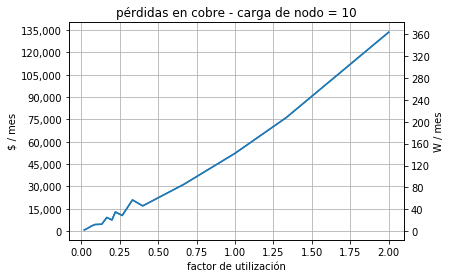

In [71]:
# cobre
a = pd.DataFrame(grupos['cpcu_nt'].min())
a['futi_nt'] = a.index
a=a.merge(una[['pcuW','cpcu_nt']],on='cpcu_nt',how='left')
y2=a['cpcu_nt']
y1=a['pcuW']
x=a['futi_nt']

fig, ax1 = plt.subplots()

ax1.plot(x,y2)
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_yticklabels(['{:,}'.format(int(x)) for x in ax1.get_yticks().tolist()])
ax1.set_ylabel('$ / mes')
ax1.tick_params(axis='y')
plt.xlabel('factor de utilización')
plt.title('pérdidas en cobre - carga de nodo = 10')
plt.grid(True)

#agregar el segundo eje
ax2 = ax1.twinx()
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax2.plot(x, y1)
ax2.set_ylabel('W / mes')

plt.show()

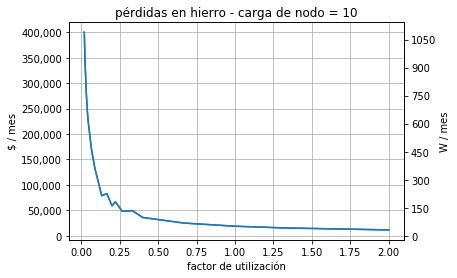

In [72]:
# hierro
a = pd.DataFrame(grupos['cpfe_nt'].min())
a['futi_nt'] = a.index
a=a.merge(una[['pfeW','cpfe_nt']],on='cpfe_nt',how='left')
y2=a['cpfe_nt']
y1=a['pfeW']
x=a['futi_nt']

fig, ax1 = plt.subplots()

ax1.plot(x,y2)
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_yticklabels(['{:,}'.format(int(x)) for x in ax1.get_yticks().tolist()])
ax1.set_ylabel('$ / mes')
ax1.tick_params(axis='y')
plt.xlabel('factor de utilización')
plt.title('pérdidas en hierro - carga de nodo = 10')
plt.grid(True)

#agregar el segundo eje
ax2 = ax1.twinx()
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax2.plot(x, y1)
ax2.set_ylabel('W / mes')

plt.show()

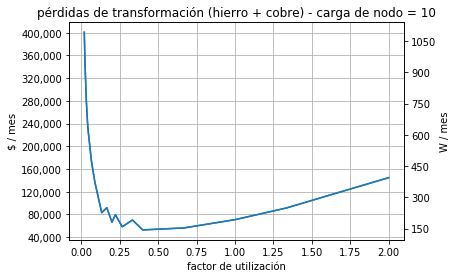

In [73]:
# de transformación (hierro + cobre)
a = pd.DataFrame(grupos['cpt_nt'].min())
a['futi_nt'] = a.index
a=a.merge(una[['ptrW','cpt_nt']],on='cpt_nt',how='left')
y2=a['cpt_nt']
y1=a['ptrW']
x=a['futi_nt']

fig, ax1 = plt.subplots()

ax1.plot(x,y2)
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_yticklabels(['{:,}'.format(int(x)) for x in ax1.get_yticks().tolist()])
ax1.set_ylabel('$ / mes')
ax1.tick_params(axis='y')
plt.xlabel('factor de utilización')
plt.title('pérdidas de transformación (hierro + cobre) - carga de nodo = 10')
plt.grid(True)

#agregar el segundo eje
ax2 = ax1.twinx()
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax2.plot(x, y1)
ax2.set_ylabel('W / mes')

plt.show()

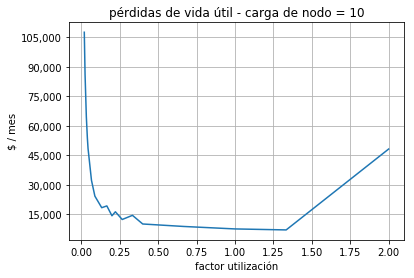

In [74]:
# de vida útil - $
df2una = df2.loc[df2['cmax']==10,:]
df2una = df2una.reset_index()
grupos = df2una.groupby(['futi_nt'])
a = pd.DataFrame(grupos['cvu_nt'].min())
ax = a.plot(y='cvu_nt')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
ax.legend_.remove()
plt.ylabel('$ / mes')
plt.xlabel('factor utilización')
plt.title('pérdidas de vida útil - carga de nodo = 10')
plt.grid(True)

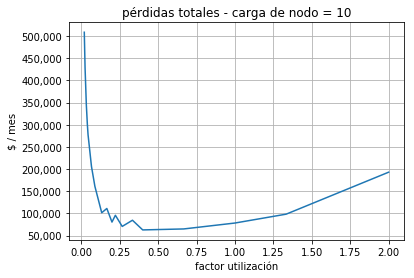

In [75]:
# totales - $
df2una = df2.loc[df2['cmax']==10,:]
df2una = df2una.reset_index()
grupos = df2una.groupby(['futi_nt'])
a = pd.DataFrame(grupos['ctotal'].min())
ax = a.plot(y='ctotal')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
ax.legend_.remove()
plt.ylabel('$ / mes')
plt.xlabel('factor utilización')
plt.title('pérdidas totales - carga de nodo = 10')
plt.grid(True)

In [76]:
## todas las gráficas (todas las cargas de nodos)
df3=df2.loc[df2['cmax'].isin([2,4,6,8,10,12,14,16,18,20])]
grupos = df3.groupby(['cmax','futi_nt'])

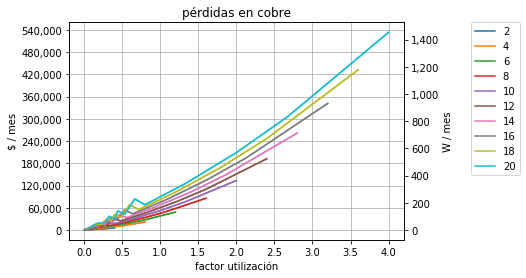

In [77]:
a = pd.DataFrame(grupos['cpcu_nt'].min())
a = a.reset_index()
a=a.merge(df3[['pcuW','cpcu_nt']],on='cpcu_nt',how='left')
a.set_index('futi_nt', inplace=True)
fig, ax1 = plt.subplots()

b = a.groupby('cmax')['cpcu_nt']
b.plot(x='futi_nt', y='cpcu_nt',ax=ax1)
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_yticklabels(['{:,}'.format(int(x)) for x in ax1.get_yticks().tolist()])
plt.ylabel('$ / mes')
plt.xlabel('factor utilización')
plt.title('pérdidas en cobre')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.)


#agregar el segundo eje
ax2 = ax1.twinx()
c = a.groupby('cmax')['pcuW']
c.plot(x='futi_nt', y='pcuW',ax=ax2)
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_yticklabels(['{:,}'.format(int(x)) for x in ax2.get_yticks().tolist()])
ax2.set_ylabel('W / mes')

plt.show()

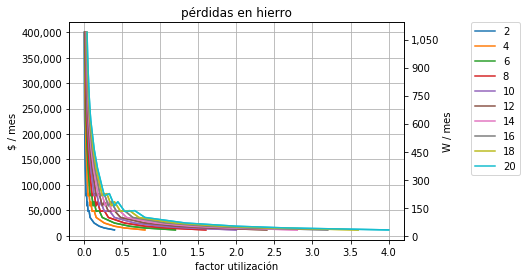

In [78]:
#hierro
a = pd.DataFrame(grupos['cpfe_nt'].min())
a = a.reset_index()
a=a.merge(df3[['pfeW','cpfe_nt']],on='cpfe_nt',how='left')
a.set_index('futi_nt', inplace=True)
fig, ax1 = plt.subplots()

b = a.groupby('cmax')['cpfe_nt']
b.plot(x='futi_nt', y='cpfe_nt',ax=ax1)
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_yticklabels(['{:,}'.format(int(x)) for x in ax1.get_yticks().tolist()])
plt.ylabel('$ / mes')
plt.xlabel('factor utilización')
plt.title('pérdidas en hierro')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.)


#agregar el segundo eje
ax2 = ax1.twinx()
c = a.groupby('cmax')['pfeW']
c.plot(x='futi_nt', y='pfeW',ax=ax2)
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_yticklabels(['{:,}'.format(int(x)) for x in ax2.get_yticks().tolist()])
ax2.set_ylabel('W / mes')

plt.show()

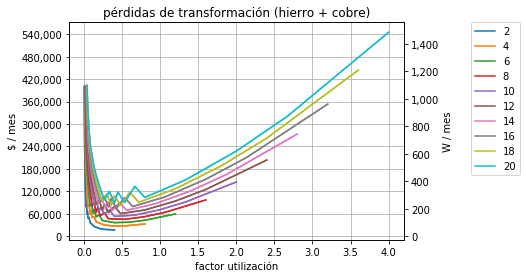

In [79]:
#de transformacion (hierro + cobre)
a = pd.DataFrame(grupos['cpt_nt'].min())
a = a.reset_index()
a=a.merge(df3[['ptrW','cpt_nt']],on='cpt_nt',how='left')
a.set_index('futi_nt', inplace=True)
fig, ax1 = plt.subplots()

b = a.groupby('cmax')['cpt_nt']
b.plot(x='futi_nt', y='cpt_nt',ax=ax1)
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_yticklabels(['{:,}'.format(int(x)) for x in ax1.get_yticks().tolist()])
plt.ylabel('$ / mes')
plt.xlabel('factor utilización')
plt.title('pérdidas de transformación (hierro + cobre)')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.)


#agregar el segundo eje
ax2 = ax1.twinx()
c = a.groupby('cmax')['ptrW']
c.plot(x='futi_nt', y='ptrW',ax=ax2)
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_yticklabels(['{:,}'.format(int(x)) for x in ax2.get_yticks().tolist()])
ax2.set_ylabel('W / mes')

plt.show()

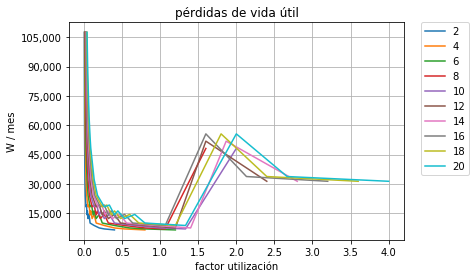

In [80]:
#de vida útil - $
a = pd.DataFrame(grupos['cvu_nt'].min())
a = a.reset_index()
a.set_index('futi_nt', inplace=True)

fig, ax = plt.subplots()
b = a.groupby('cmax')['cvu_nt'].plot(x='futi_nt', y='cvu_nt',ax=ax)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
plt.ylabel('W / mes')
plt.xlabel('factor utilización')
plt.title('pérdidas de vida útil')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

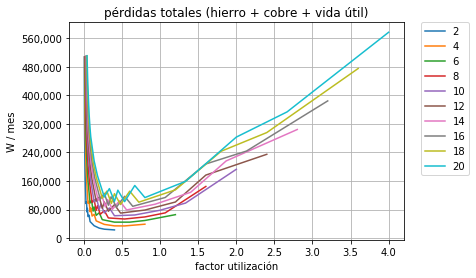

In [81]:
#totales - $
a = pd.DataFrame(grupos['ctotal'].min())
a = a.reset_index()
a.set_index('futi_nt', inplace=True)
fig, ax = plt.subplots()
b = a.groupby('cmax')['ctotal'].plot(x='futi_nt', y='ctotal',ax=ax)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
plt.ylabel('W / mes')
plt.xlabel('factor utilización')
plt.title('pérdidas totales (hierro + cobre + vida útil)')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()